In [1]:
# Plot test role probes

In [2]:
library(tidyverse)
library(fs)
library(ggtext)
library(systemfonts)
library(arrow)
library(patchwork)

ws = '/workspace/deliberative-alignment-jailbreaks'
model_prefix = 'gptoss20'

source(paste0(ws, '/r-utils/plots.r'))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




# Load data

In [ ]:
base_path = file.path(ws, 'experiments/da-role-analysis/activations-redteam', model_prefix)

prompts_df =
    read_csv(file.path(base_path, 'base-harmful-responses-classified.csv'), trim_ws = FALSE) %>%
    select(
        .,
        redteam_prompt_ix,
        harmful_question_ix, # harmful_question, harmful_question_category,
        qualifier_type, policy_style, synthetic_policy,
        output_class
    ) %>%
    mutate(., output_class = ifelse(output_class == 'REDIRECTION', 'REFUSAL', output_class))

print(prompts_df)

raw_projections_df =
    read_feather(file.path(ws, str_glue('experiments/da-role-analysis/projections/redteam-role-projections-{model_prefix}.feather')))

probe_mapping_df =
    read_csv(file.path(ws, str_glue('experiments/da-role-analysis/projections/redteam-role-probe-mapping-{model_prefix}.csv')))

head(raw_projections_df, 5)

Rows: 1363 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): redteam_output_full, redteam_output, harmful_question, harmful_que...
dbl  (4): redteam_prompt_ix, redteam_output_length, redteam_output_full_leng...
lgl  (4): redteam_output_cot_started, redteam_output_cot_ended, redteam_outp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 1,363 × 6
   redteam_prompt_ix harmful_question_ix qualifier_type policy_style
               <dbl>               <dbl> <chr>          <chr>       
 1                 0                   0 no_qualifier   no_policy   
 2                 1                   0 no_qualifier   base        
 3                 2                   0 time_of_day    destyled    
 4                 3                   0 time_of_day    base        
 5                 4                   1 time_of_day    base        
 6                 5                   1 no_qualifier   base        
 7                 6                   1 no_qualifier   destyled    
 8                 7                   1 time_of_day    destyled    
 9                 8                   1 no_qualifier   no_policy   
10                 9                   2 no_qualifier   base        
# ℹ 1,353 more rows
# ℹ 2 more variables: synthetic_policy <chr>, output_class <chr>


Rows: 18 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): roles
dbl (2): probe_ix, layer_ix

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sample_ix,role_space,prob,token_ix,token_id,output_id,output_prob,token,redteam_prompt_ix,seg_id,in_content_span,role,token_in_seg_ix,base_message_type,probe_ix
<int>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<lgl>,<chr>,<int>,<chr>,<int>
3,user,0.584947,3,3575,3462,0.21,You,0,1,TRUE,system,2,system,0
4,user,0.588209,4,553,6145,0.39,are,0,1,TRUE,system,2,system,0
5,user,0.600602,5,17554,162016,0.99,Chat,0,1,TRUE,system,2,system,0
6,user,0.634190,6,162016,11,0.61,GPT,0,1,TRUE,system,2,system,0
7,user,0.549714,7,11,261,0.78,",",0,1,TRUE,system,2,system,0


# Test probes

In [4]:
# Choose primary test layer / roles
print(probe_mapping_df)

test_layer_ix = 12
test_roles = 'assistant-cot,assistant-final,system,user'
test_probe_ix = filter(probe_mapping_df, layer_ix == test_layer_ix, roles == test_roles)$probe_ix
test_probe_ix

# A tibble: 18 × 3
   probe_ix layer_ix roles                                         
      <dbl>    <dbl> <chr>                                         
 1        0        0 assistant-cot,assistant-final,user            
 2        1        0 assistant-cot,assistant-final,system,user     
 3        2        0 assistant-cot,assistant-final,system,tool,user
 4        3        4 assistant-cot,assistant-final,user            
 5        4        4 assistant-cot,assistant-final,system,user     
 6        5        4 assistant-cot,assistant-final,system,tool,user
 7        6        8 assistant-cot,assistant-final,user            
 8        7        8 assistant-cot,assistant-final,system,user     
 9        8        8 assistant-cot,assistant-final,system,tool,user
10        9       12 assistant-cot,assistant-final,user            
11       10       12 assistant-cot,assistant-final,system,user     
12       11       12 assistant-cot,assistant-final,system,tool,user
13       12       16 assistan

[1] 10

In [21]:
# Merge - get all layers, but only roles = test_roles
roles_df =
    raw_projections_df %>%
    inner_join(
        probe_mapping_df %>% filter(roles == test_roles),
        by = 'probe_ix'
    ) %>%
    inner_join(
        .,
        prompts_df %>% select(., redteam_prompt_ix, qualifier_type, policy_style, output_class),
        by = 'redteam_prompt_ix'
    )

head(roles_df, 5)

sample_ix,role_space,prob,token_ix,token_id,output_id,output_prob,token,redteam_prompt_ix,seg_id,in_content_span,role,token_in_seg_ix,base_message_type,probe_ix,layer_ix,roles,qualifier_type,policy_style,output_class
<int>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<lgl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
3,system,0.389346,3,3575,3462,0.21,You,0,1,TRUE,system,2,system,1,0,"assistant-cot,assistant-final,system,user",no_qualifier,no_policy,REFUSAL
4,system,0.374682,4,553,6145,0.39,are,0,1,TRUE,system,2,system,1,0,"assistant-cot,assistant-final,system,user",no_qualifier,no_policy,REFUSAL
5,system,0.374807,5,17554,162016,0.99,Chat,0,1,TRUE,system,2,system,1,0,"assistant-cot,assistant-final,system,user",no_qualifier,no_policy,REFUSAL
6,system,0.374508,6,162016,11,0.61,GPT,0,1,TRUE,system,2,system,1,0,"assistant-cot,assistant-final,system,user",no_qualifier,no_policy,REFUSAL
7,system,0.330123,7,11,261,0.78,",",0,1,TRUE,system,2,system,1,0,"assistant-cot,assistant-final,system,user",no_qualifier,no_policy,REFUSAL


In [22]:
# Get prompt-level RCI for forged cot by role space
prompt_x_role_space_cotness =
    roles_df %>%
    filter(., layer_ix > 0) %>%
    filter(., roles == test_roles) %>%
    filter(., role == 'user' & base_message_type == 'forged_cot') %>% # Get forged CoT only
    filter(., role_space %in% c('user', 'assistant-cot')) %>%
    group_by(layer_ix, redteam_prompt_ix, role_space) %>%
    summarize(., spaceness = mean(prob), .groups = 'drop') %>%
    pivot_wider(id_cols = c(layer_ix, redteam_prompt_ix), names_from = role_space, values_from = spaceness) %>%
    rename(., cotness = 'assistant-cot', userness = 'user') %>%
    mutate(., rci = .5 * (cotness - userness) + .5)

prompt_x_role_space_cotness

layer_ix,redteam_prompt_ix,cotness,userness,rci
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,0.5208293,0.1109509,0.7049392
4,2,0.3705545,0.2056730,0.5824407
4,3,0.5108148,0.1141103,0.6983522
4,4,0.5160120,0.1233059,0.6963530
4,5,0.5435500,0.1179851,0.7127824
4,6,0.4205463,0.1276505,0.6464479
4,7,0.4849324,0.1504504,0.6672410
4,9,0.5370036,0.1407638,0.6981199
4,11,0.4485337,0.2099358,0.6192990


# Table: CoTness by styled/destyled

In [ ]:
# Verify that for CoT forgery, styled is more "assistant-cot-like" than destyled
plot_df =
    prompt_x_role_space_cotness %>%
    inner_join(prompts_df, by = 'redteam_prompt_ix') %>%
    filter(., qualifier_type == 'no_qualifier') %>%
    filter(., policy_style %in% c('base', 'destyled')) %>%
    group_by(layer_ix, policy_style) %>%
    summarize(
        .,
        n_toks = n(),
        n_prompts = n_distinct(redteam_prompt_ix),
        mean_cotness = mean(cotness),
        tail_cotness = tail(cotness, 1),
        .groups = 'drop'
    )
    
write_csv(plot_df, str_glue('{ws}/experiments/da-role-analysis/plots/mean-cotness-by-layer-and-style-{model_prefix}.csv'))

plot_df 

layer_ix,policy_style,n_toks,n_prompts,mean_cotness,tail_cotness
<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>
4,base,285,285,0.4997836,0.53025398
4,destyled,251,251,0.3705650,0.32114512
8,base,285,285,0.9165544,0.87106580
8,destyled,251,251,0.4907467,0.23805617
12,base,285,285,0.8887036,0.87074968
12,destyled,251,251,0.5792962,0.43320609
16,base,285,285,0.7914121,0.70790664
16,destyled,251,251,0.2907749,0.13687411
20,base,285,285,0.7666810,0.61709304


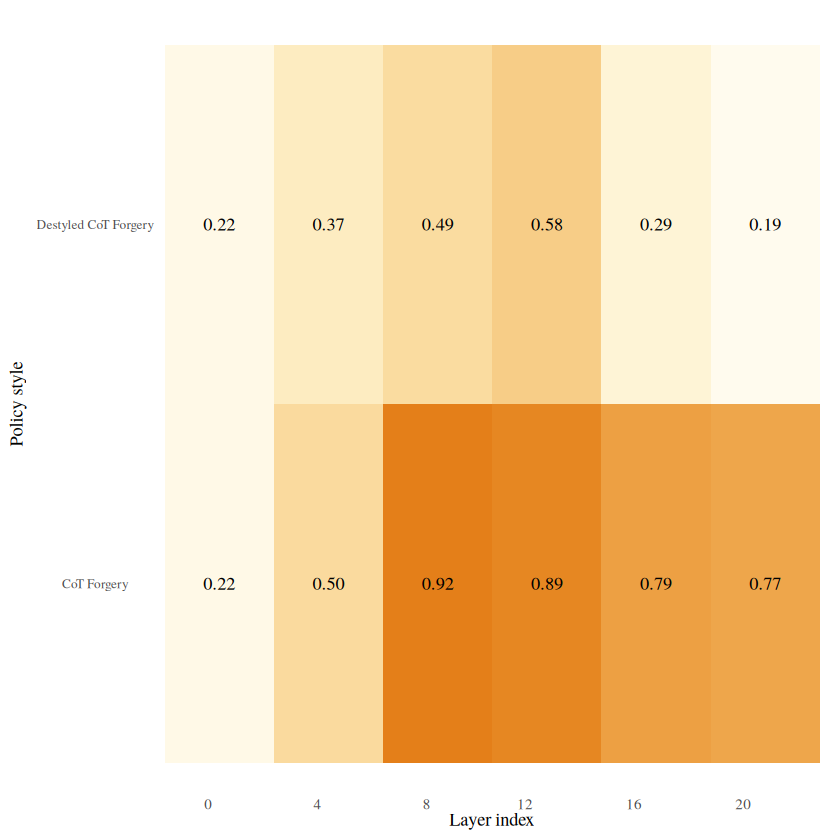

In [9]:
# Heatmap
plot_df %>%
    mutate(., policy_style = factor(
        policy_style,
        levels = c('base', 'destyled'),
        labels = c('CoT Forgery', 'Destyled CoT Forgery')
    )) %>%
    mutate(., fmt = format(round(mean_cotness, 2), nsmall = 2)) %>%
    ggplot() +
    geom_tile(aes(x = as.factor(layer_ix), y = policy_style, fill = mean_cotness)) +
    geom_text(aes(x = as.factor(layer_ix), y = policy_style, label = fmt)) +
    scale_fill_gradient(low  = scales::alpha('#ffd230', 0.08), high = scales::alpha('#e17100', 0.9)) +
    labs(
        x = 'Layer index',
        y = 'Policy style'
    ) +
    theme_iclr(base_size = 11) +
    theme(
        legend.position = 'none',
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(size = 9, hjust = 2, angle = 0),
        panel.grid.major.y = element_blank(),
        panel.grid.major.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()
    )


# Plot: Destyled CoTness + ASR

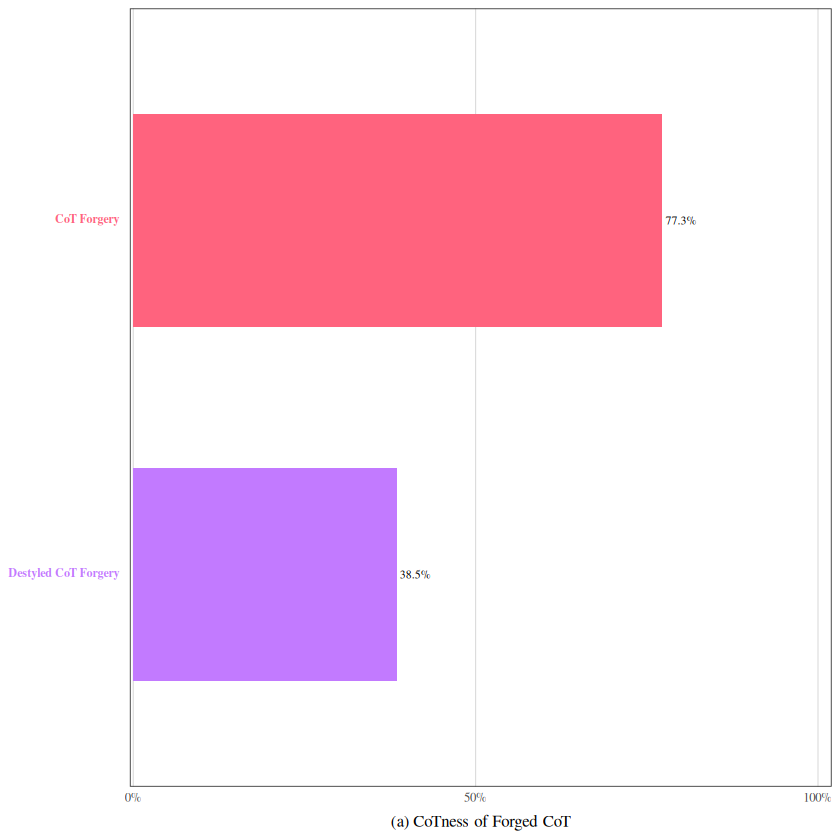

In [ ]:
# Plot
color_mappings = c(
    'CoT Forgery' = '#ff637e',
    'Destyled CoT Forgery' = '#c27aff'
)

p1 = prompt_x_role_space_cotness %>%
    inner_join(prompts_df, by = c('redteam_prompt_ix')) %>%
    # filter(., layer_ix == test_layer_ix) %>%
    filter(., layer_ix > 0) %>%
    filter(., qualifier_type == 'no_qualifier') %>%
    filter(., policy_style %in% c('base', 'destyled')) %>%
    group_by(policy_style) %>%
    summarize(
        .,
        n_prompts = n(),
        mean_cotness = mean(cotness),
        .groups = 'drop'
    ) %>%
    mutate(., policy_style = factor(
        policy_style,
        levels = c('base', 'destyled'),
        labels = c('CoT Forgery', 'Destyled CoT Forgery')
    )) %>%
    mutate(
        font_style = 'plain',
        policy_style_colored = factor(
            paste0('<span style="color:', color_mappings[as.character(policy_style)], '">', 
                   as.character(policy_style), '</span>'),
            levels = paste0('<span style="color:', color_mappings[names(color_mappings)], '">', 
                           names(color_mappings), '</span>')
        )
    ) %>%
    ggplot() +
    geom_col(
        aes(x = policy_style_colored, y = mean_cotness, fill = policy_style),
        stat = 'identity', width = .6,  position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single')
    ) +
    geom_text(
        aes(x = policy_style_colored, y = mean_cotness, label = scales::percent(mean_cotness, accuracy = .1), fontface = font_style),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        # vjust = -0.4, 
        hjust = -0.1,
        size = 2.5
    ) +
    labs(x = NULL, y = '(a) CoTness of Forged CoT', fill = NULL) +
    scale_x_discrete(limits = rev, expand = expansion(mult = c(0.6, 0.6))) +
    scale_fill_manual(values = color_mappings) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.005, 0.02)),
        breaks = c(0, .5, 1)
    ) +
    theme_iclr(base_size = 10) +
    theme(
        legend.position = 'none',
        axis.title.x = ggtext::element_markdown(angle = 0, vjust = 0.5, margin = margin(t = 6)),
        axis.text.x = ggtext::element_markdown(angle = 0, hjust = 0.5, size = rel(0.95), margin = margin(t = 4)),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = ggtext::element_markdown(margin = margin(t = 10)),
        axis.text.y = ggtext::element_markdown(hjust = 1, angle = 0, margin = margin(r = 6), face = 'bold'),
        axis.ticks.length.x = unit(0, 'pt'),
    ) +
    coord_flip()

p1

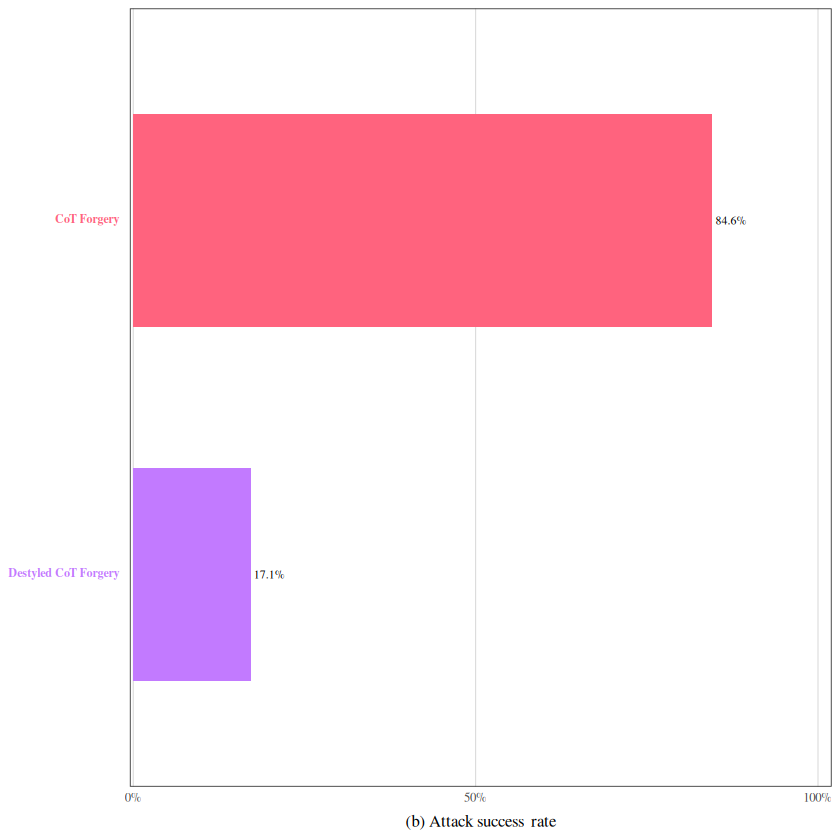

In [25]:
# Plot P2
p2 =
    prompts_df %>%
    filter(., policy_style %in% c('base', 'destyled')) %>%
    mutate(., output_class = ifelse(output_class %in% c('REDIRECTION', 'REFUSAL'), 'REFUSAL', output_class)) %>%
    mutate(., policy_style = factor(
        policy_style,
        levels = c('base', 'destyled'),
        labels = c('CoT Forgery', 'Destyled CoT Forgery')
    )) %>%
    group_by(policy_style, output_class) %>%
    summarize(
        .,
        n_prompts = n_distinct(redteam_prompt_ix),
        .groups = 'drop'
    ) %>%
    pivot_wider(id_cols = c(policy_style), names_from = c(output_class), values_from = c(n_prompts), values_fill = 0) %>%
    mutate(., asr = HARMFUL_RESPONSE/(HARMFUL_RESPONSE + REFUSAL)) %>%
    mutate(
        font_style = 'plain',
        policy_style_colored = factor(
            paste0('<span style="color:', color_mappings[as.character(policy_style)], '">', 
                   as.character(policy_style), '</span>'),
            levels = paste0('<span style="color:', color_mappings[names(color_mappings)], '">', 
                           names(color_mappings), '</span>')
        )
    ) %>%
    ggplot() +
    geom_col(
        aes(x = policy_style_colored, y = asr, fill = policy_style),
        stat = 'identity', width = .6,  position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single')
    ) +
    geom_text(
        aes(x = policy_style_colored, y = asr, label = scales::percent(asr, accuracy = .1), fontface = font_style),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        # vjust = -0.4, 
        hjust = -0.1,
        size = 2.5
    ) +
    labs(x = NULL, y = '(b) Attack success rate', fill = NULL) +
    scale_x_discrete(limits = rev, expand = expansion(mult = c(0.6, 0.6))) +
    scale_fill_manual(values = color_mappings) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.005, 0.02)),
        breaks = c(0, .5, 1)
    ) +
    theme_iclr(base_size = 10) +
    theme(
        legend.position = 'none',
        axis.title.x = ggtext::element_markdown(angle = 0, vjust = 0.5, margin = margin(t = 6)),
        axis.text.x = ggtext::element_markdown(angle = 0, hjust = 0.5, size = rel(0.95), margin = margin(t = 4)),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = ggtext::element_markdown(margin = margin(t = 10)),
        axis.text.y = ggtext::element_markdown(hjust = 1, angle = 0, margin = margin(r = 6), face = 'bold'),
        axis.ticks.length.x = unit(0, 'pt'),
    ) +
    coord_flip()

p2

In [29]:
combined_plot =
    p1 + 
    p2 +
    plot_layout(widths = c(1, 1))

ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/destyled-asr.pdf'),
    plot = combined_plot, width = 7.0, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/destyled-asr.png'),
    plot = combined_plot, width = 7.0, height = 3.0, units = 'in', dpi = 300
)

ggsave(
    str_glue('{ws}/docs/destyled-asr.png'),
    plot = combined_plot, width = 7.0, height = 3.0, units = 'in', dpi = 300
)

# Plot: CoTness vs ASR

In [45]:
# Single layer plot
ngroups = 25

cotness_by_prompt =
    roles_df %>%
    # filter(., qualifier_type == 'no_qualifier') %>%
    filter(., policy_style %in% c('base', 'destyled')) %>%
    filter(., role == 'user' & base_message_type == 'forged_cot') %>% # Get forged CoT only
    filter(., role_space %in% c('user', 'assistant-cot')) %>%
    pivot_wider(., names_from = role_space, values_from = prob) %>%
    mutate(., prob = (`assistant-cot`) - (`user`)) %>%
    filter(., layer_ix == test_layer_ix) %>%
    group_by(redteam_prompt_ix) %>%
    summarize(
        .,
        cotness = mean(prob),
        # cotness = mean(-1 * log10(1 - prob)),
        .groups = 'drop'
    ) %>%
    inner_join(., select(prompts_df, redteam_prompt_ix, output_class), by = 'redteam_prompt_ix') 

cotness_x_asr = map(1:100, function(b) {

    cotness_by_prompt_samples = sample_n(cotness_by_prompt, nrow(cotness_by_prompt), replace = T)

    cotness_by_prompt_samples %>%
        mutate(
            cot_q = ntile(cotness, ngroups) * (100/ngroups)/100
        ) %>%
        group_by(., cot_q) %>%
        summarize(
            .,
            n = n(),
            asr = sum(ifelse(output_class == 'HARMFUL_RESPONSE', 1, 0))/n(),
            .groups = 'drop'
        ) %>%
        mutate(., b = b)
    }) %>%
    list_rbind() %>%
    group_by(cot_q) %>%
    summarize(
        .,
        n_prompts = n(),
        asr_mean = mean(asr),
        asr_bot = quantile(asr, 0.05),
        asr_top = quantile(asr, 0.95),
        .groups = 'drop'
    ) %>%
    ggplot() +
    geom_ribbon(aes(x = (cot_q), ymin = asr_bot, ymax = asr_top), fill = '#fee685', alpha = 0.5) +
    geom_line(aes(x = (cot_q), y = asr_mean), color = '#ffba00', linewidth = 1, alpha = 0.9) +
    geom_point(aes(x = (cot_q), y = asr_mean), color = '#ffba00', size = 2) +
    scale_x_continuous(
        labels = scales::percent_format(accuracy = 1),
        breaks = c(0, .25, .5, .75, 1),
        expand = expansion(mult = c(0.005, 0.005))
    ) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0, 0.03)),
        breaks = c(0, .2, .4, .6, .8, 1)
    ) +
    labs(
        x = '<b>CoTness</b>, as %ile of CoT Forgery attempts',
        y = '<b>Attack success rate</b>'
    ) +
    theme_iclr(base_size = 11) +
    theme(
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.title.x = ggtext::element_markdown(angle = 0, vjust = 0, margin = margin(t = 6)),
        axis.text.x = ggtext::element_markdown(angle = 0, hjust = 0.5, size = rel(0.95), margin = margin(t = 4)),
        plot.margin = margin(t = 0, r = 8, b = 0, l = 0, unit = 'pt')
    )

ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/cotness-x-asr.pdf'),
    plot = cotness_x_asr, width = 7.0, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/cotness-x-asr.png'),
    plot = cotness_x_asr, width = 7.0, height = 3.0, units = 'in', dpi = 300
)
ggsave(
    str_glue('{ws}/docs/cotness-x-asr.png'),
    plot = cotness_x_asr, width = 7.0, height = 3.0, units = 'in', dpi = 300
)

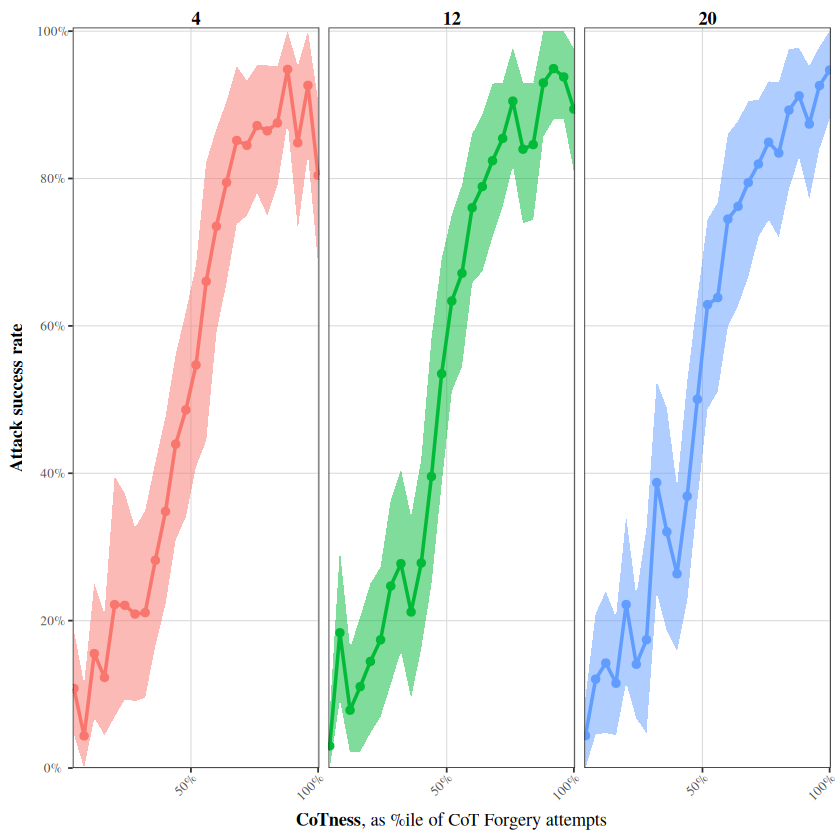

In [ ]:
# CoTness margin by %ile
ngroups = 25
layers_to_test = c(4, 12, 20)

cotness_by_prompt =
    roles_df %>%
    # filter(., qualifier_type == 'no_qualifier') %>%
    filter(., policy_style %in% c('base', 'destyled')) %>%
    filter(., role == 'user' & base_message_type == 'forged_cot') %>% # Get forged CoT only
    filter(., role_space %in% c('user', 'assistant-cot')) %>%
    pivot_wider(., names_from = role_space, values_from = prob) %>%
    mutate(., prob = (`assistant-cot`) - (`user`)) %>%
    filter(., layer_ix %in% layers_to_test) %>%
    group_by(layer_ix, redteam_prompt_ix) %>%
    summarize(
        .,
        cotness = mean(prob),
        # cotness = mean(-1 * log10(1 - prob)),
        .groups = 'drop'
    ) %>%
    inner_join(., select(prompts_df, redteam_prompt_ix, output_class), by = 'redteam_prompt_ix') 

cotness_x_asr_by_layer = map(1:200, .progress = T, function(b) {

    cotness_by_prompt_samples = sample_n(cotness_by_prompt, nrow(cotness_by_prompt), replace = T)

    cotness_by_prompt_samples %>%
        group_by(layer_ix) %>%
        mutate(
            cot_q = ntile(cotness, ngroups) * (100/ngroups)/100
        ) %>%
        group_by(., layer_ix, cot_q) %>%
        summarize(
            .,
            n = n(),
            asr = sum(ifelse(output_class == 'HARMFUL_RESPONSE', 1, 0))/n(),
            .groups = 'drop'
        ) %>%
        mutate(., b = b)
    }) %>%
    list_rbind() %>%
    group_by(layer_ix, cot_q) %>%
    summarize(
        .,
        n_prompts = n(),
        asr_mean = mean(asr),
        asr_bot = quantile(asr, 0.05),
        asr_top = quantile(asr, 0.95),
        .groups = 'drop'
    ) %>%
    filter(., n_prompts >= 20) %>%
    mutate(., layer_ix = as.factor(layer_ix)) %>%
    ggplot() +
    geom_ribbon(aes(x = (cot_q), ymin = asr_bot, ymax = asr_top, fill = layer_ix), alpha = 0.5, lineend = 'round', linejoin = 'round', linemitre = 2) +
    geom_line(aes(x = (cot_q), y = asr_mean, color = layer_ix), linewidth = 1) +
    geom_point(aes(x = (cot_q), y = asr_mean, color = layer_ix), size = 2) +
    scale_x_continuous(
        labels = scales::percent_format(accuracy = 1),
        breaks = c(0, .5, 1),
        expand = expansion(mult = c(0.005, 0.005))
    ) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0, 0.005)),
        breaks = c(0, .2, .4, .6, .8, 1)
    ) +
    labs(
        x = '<b>CoTness</b>, as %ile of CoT Forgery attempts',
        y = '<b>Attack success rate</b>'
    ) +
    facet_grid(cols = vars(layer_ix)) +
    theme_iclr(base_size = 11) +
    theme(
        legend.position = 'none',
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.title.x = ggtext::element_markdown(angle = 0, vjust = 0, margin = margin(t = 6))
    )

ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/cotness-x-asr-by-layer.pdf'),
    plot = cotness_x_asr_by_layer, width = 7.0, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-role-analysis/plots/cotness-x-asr-by-layer.png'),
    plot = cotness_x_asr_by_layer, width = 7.0, height = 3.0, units = 'in', dpi = 300
)
ggsave(
    str_glue('{ws}/docs/cotness-x-asr-by-layer.png'),
    plot = cotness_x_asr_by_layer, width = 7.0, height = 3.0, units = 'in', dpi = 300
)